# NLP on Amazon Laptop Reviews

### MSCA 31008 - Summer 2021
* Alessandro Joabar
* Adam Schuller
* Bogdan Constantinescu
* Bryan E Duff

## Executive Summary

* We can predict exactly how many stars a customer will rate a laptop based on their review text with an accuracy of 73%

* We can predict whether or not a product will have a positive rating (3+ stars) with an accuracy of 91%
* We can predict whether or not a product will have a negative rating (1-star) with an accuracy of 91%


## Objective
We would like to leverage Amazon customer review and rating data to understand if we can accurately predict:
* The number of stars a customer rates a laptop based on the words they use in their review.
* If a review will come in with 3+ stars based on the words used in the review.
* If a review will come in with a 1-star review.


## Data
We are going to import the Amazon laptop review data. This data was generated by taking the various Laptop brands in our initial dataset, and pulling the top 10 SKUs on Amazon and their respective reviews and ratings via a RapidAPI subscription. We chose to aggregate the laptop reviews by brand rather than product for a few reasons:

* Products can have slight differences in specs but be categorized as different products, and they can create a lot of unecessary granularity in our data

* Overall, a brand's products will all share similiar traits, and we would expect this to show in the data (i.e, Apple: expensive but beautiful; Asus: extremely reliable, high quality; etc.)


In [1]:
import pandas as pd
import numpy as np
import scipy as scp
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

reviews = pd.read_csv('reviews.csv')
reviews = reviews.drop(columns='Unnamed: 0')
reviews.head()

,Company,Review,Rating
0,Apple,Thoroughly satisfied with my purchase,5
1,Apple,excelente excelente,5
2,Apple,Apple M1 chip does not support two external Mo...,2
3,Apple,What did you expect? It's a Mac!,5
4,Apple,"great product so far, very happy with it. Very...",5


Starting from the top, here are the highest rated brands based on average rating.

In [2]:
top = reviews.groupby('Company').mean()
top['Number of Reviews'] = reviews.groupby('Company').sum()
top.sort_values(by='Rating', ascending=False).head(10)

,Rating,Number of Reviews
Company,,
Vero,4.505155,437
LG,4.207407,568
MSI,4.154412,565
Lenovo,4.101010,406
Samsung,3.981707,653
Fujitsu,3.927928,436
Asus,3.927007,538
Dell,3.924528,416
Microsoft,3.866667,464


## Methodology

In NLP, reducing dimensionality is crucial. We will use `TfidfVectorizer` to break apart the review terms. From there, we can apply PCA to reduce dimensionality.

In [3]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
text = reviews['Review']

# Create a TfidfVectorizer: tfidf
tfidf = TfidfVectorizer() 

# Apply fit_transform to csr matrix
review_vector = tfidf.fit_transform(text)
review_vector.shape

(2676, 8906)

Looking at the initial terms we vectorized, we are seeing a lot of individual terms which are not really relevant. In the next step we will do two things:
* Remove terms with numbers (tentative)
* We will do language checks to remove random typos (for this exercise, English, Spanish, French)

In [4]:
words = tfidf.get_feature_names()
words[0:20]

['00',
 '000',
 '0064f45bpart',
 '01',
 '01on',
 '04',
 '06',
 '07',
 '08',
 '10',
 '100',
 '1000',
 '1000gb',
 '100c',
 '100fps',
 '100s',
 '100w',
 '100whr',
 '10300hgpu',
 '1035g1']

In [5]:
rev_array = review_vector.toarray()
words_df = pd.DataFrame(rev_array, columns = words)
words_df.head()

,00,000,0064f45bpart,01,01on,04,06,07,08,10,...,zoom,zoomed,zooming,zooms,zsh,ágil,última,último,único,útil
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There are two important filters we need to use when parsing through the unique words in these reviews:
* We should remove strings with numbers since they seem to be irrelevant outside a specific context. We also notice a large boost in model score when we add this filter.
* To remove typo's, we will leverage the `enchant` library to check that these terms are in the dictionary. This will help us remove words that might not be helpful.

We noticed that some words being filtered out had a negative impact on model score, so we only check a few different languages. This can be improved upon in future versions.

Note: We can implement an autocorrect feature to send typo's to their intended term.

In [6]:
import enchant
eng = enchant.Dict("en")
span = enchant.Dict('es')
fre = enchant.Dict('fr')
de = enchant.Dict('de')
it = enchant.Dict('it')
drops = []
for column in words_df.columns:
    english = eng.check(column)
    spanish = span.check(column)
    french = fre.check(column)
    german  = de.check(column)
    italian = it.check(column)
    if any(map(str.isdigit, column)): 
        drops.append(column)
    if not(english | spanish | french | german | italian):
        drops.append(column)

words_df = words_df.drop(columns = drops)
words_df.head()

,abajo,abandoned,ability,able,abnormalities,abolladuras,about,above,absent,absolute,...,zona,zoom,zoomed,zooming,zooms,ágil,última,último,único,útil
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Through this filtering we've removed almost 2K words. This will help reduce dimensionality when we create models to predict rating score.

In [7]:
review_vector = scp.sparse.csr_matrix(words_df.values)
review_vector.shape

(2676, 6985)

<AxesSubplot:title={'center':'Fraction of Explained Variance'}, xlabel='Dimension #', ylabel='Explained Variance Ratio'>

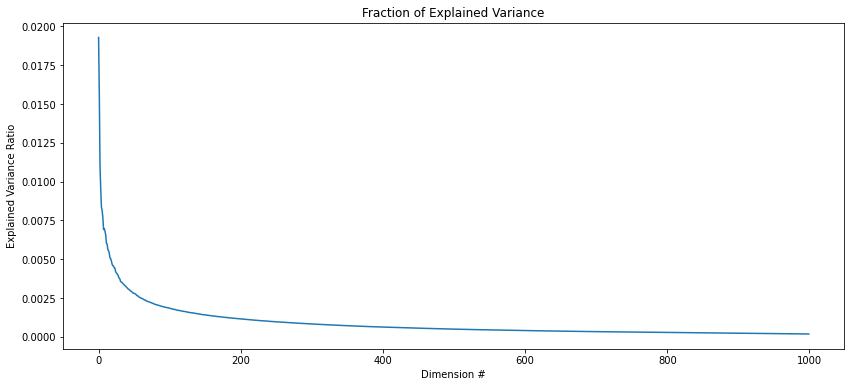

In [8]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
svd = TruncatedSVD(n_components=1000)
svd.fit(review_vector)
features = range(svd.n_components) 
fig, ax = plt.subplots(figsize=(14,6))
ax.set_title("Fraction of Explained Variance")
ax.set_xlabel("Dimension #")
ax.set_ylabel("Explained Variance Ratio")
plt.plot(features, svd.explained_variance_ratio_)
ax

We have 6985 distinct terms in our review data. By using TruncatedSVD, we can reduce dimensionality down to 777 components to explain ~85% in variance.

In [9]:
n_comps = 0
ev = 0
for comp in svd.explained_variance_ratio_:
    if ev + comp <= 0.85:
        n_comps = n_comps + 1
        ev = ev + comp

print("Optimal N Components: " + str(n_comps))
print("Explained Variance: " + str(ev))

Optimal N Components: 777
Explained Variance: 0.8499886865896039


In [10]:
svd2 = TruncatedSVD(n_components = n_comps)
t = svd2.fit_transform(review_vector)
t = pd.DataFrame(t)
t.shape

(2676, 777)

We can fit that data back to a data frame and list the columns accordingly.

In [11]:
for column in t:
        col = t[column]
        col_name = t[column].name
        new_name = "Component_" + str(col_name)
        t = t.rename(columns={col_name: new_name})
t['Rating'] = reviews['Rating']
t.head()

,Component_0,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7,Component_8,Component_9,...,Component_768,Component_769,Component_770,Component_771,Component_772,Component_773,Component_774,Component_775,Component_776,Rating
0,0.070551,0.014636,-0.025105,-0.012334,-0.021312,0.028501,0.062881,0.011523,-0.030252,0.009522,...,-0.002433,-0.000077,0.002903,0.002590,0.001247,0.007072,-0.005348,0.008097,0.003810,5
1,0.001132,0.004762,-0.004698,0.004216,0.063408,-0.018864,0.087361,0.270264,0.293683,0.057021,...,0.004859,0.004322,0.000615,-0.000247,0.002456,0.009758,-0.003198,0.005532,0.007295,5
2,0.195150,-0.048485,-0.007503,-0.040549,-0.041354,-0.011876,-0.015744,0.036774,-0.035365,-0.013638,...,0.010756,0.002341,-0.004996,0.003417,-0.003792,-0.010663,0.002681,-0.004614,-0.005348,2
3,0.120096,-0.021025,0.066543,0.035591,-0.097347,-0.071523,0.055934,-0.006864,0.006414,-0.126204,...,0.002511,-0.005490,-0.000845,0.001165,0.003700,-0.013581,0.009564,-0.001371,0.003528,5
4,0.264674,0.334021,0.002000,0.000466,-0.088095,0.064278,-0.079453,0.283830,-0.271988,-0.124903,...,0.005724,-0.015622,-0.008211,-0.005227,-0.000688,-0.001101,0.002358,0.000811,0.005989,5


In [12]:
words_df['Rating'] = reviews['Rating']
words_df.head()

,abajo,abandoned,ability,able,abnormalities,abolladuras,about,above,absent,absolute,...,zoom,zoomed,zooming,zooms,ágil,última,último,único,útil,Rating
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


Here we are going to write functions that will help us classify how a customer might rate a laptop based on the words used in their review. Now, you might ask, "Why do you want to create a model that predicts the rating of a product after it has already launched and reviewed? Where is the value in that?"

If this model is effective, a business will be able use this model and other text data to better predict how a product might be received in the marketplace. Furthermore, if a company is designing a new product, they can predict whether or not it will be recieved well based on consumer insight data they collect pre-launch.

For example, if Asus is testing a brand new laptop for 2023, and they have collected surveys and reviews from a test audience, they can actually run those reviews through the model and predict the customer reaction to the product quantitatively.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Helper function to run model on relevant data
def build_models_on_train(df, model, X_train, X_test, y_train, y_test):   
    classifier = model()
    classifier.fit(X_train, y_train)
    return classifier

# Our workhorse AutoML function - runs different models and prints results with great flexibility
def select_best_model_score(df):
    # Partition data into features and labels
    feature_cols = df.columns[df.columns != 'Rating']
    X = df[feature_cols] # Features
    y = df.Rating # Label
    
    # Create train and test segments
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)
    
    models_to_run = [LogisticRegression, LinearSVC, MLPClassifier, 
                 DecisionTreeClassifier, RandomForestClassifier, GaussianNB,
                Perceptron, MLPClassifier, SGDClassifier]
    
    # Score tracking
    max_score = 0
    max_build = 0
    max_RMSE = 999999
    
    for algo in models_to_run:
        build = build_models_on_train(df, algo, X_train, X_test, y_train, y_test)
        pred = build.predict(X_test)
        RMSE = np.sqrt(metrics.mean_squared_error(y_test, pred))

        if RMSE < max_RMSE:
            max_score = build.score(X_test, y_test)
            max_build = build
            max_RMSE = RMSE        
    predicted = max_build.predict(X_test)
    
    print()
    print("Best build model is: ")
    print(max_build)
    print("Build model score (Accuracy): " + str(max_score))
    print("MAE = {:5.4f}".format(metrics.mean_absolute_error(y_test, predicted)))
    print("MSE = {:5.4f}".format(metrics.mean_squared_error(y_test, predicted)))
    print("RMSE = {:5.4f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))
    
    # Results of model if binary classification
    if len(y.unique()) < 3:
        print("Accuracy:",metrics.accuracy_score(y_test, predicted))
        print("Precision:",metrics.precision_score(y_test, predicted))
        print("Recall:",metrics.recall_score(y_test, predicted))

        cnf_matrix = metrics.confusion_matrix(y_test, predicted)
        class_names=[0,1]
        fig, ax = plt.subplots()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
        sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
        ax.xaxis.set_label_position("top")
        plt.tight_layout()
        plt.title('Confusion matrix', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
    
    output = pd.DataFrame()
    inp = pd.DataFrame()
    inp['Ratings'] = y_test
    output['Ratings'] = predicted
    
    # Results of model if more than 2 possible classifications
    if len(y.unique()) > 2:
        sns.distplot(inp['Ratings'])
        sns.distplot(output['Ratings']).set_title(str(max_build) + " Test vs. Predicted")

    return max_build, predicted

We are going to build two models for 1) exact star rating and 2) if ratings are 3+ stars: 
* Mark 1 will be with all the words found in the reviews predicting on Rating (words_df)
* Mark 2 will be the truncated SVD dataset predicting on Rating (t)

### Predicting Star Ratings

#### TF-IDF Data


Best build model is: 
Perceptron()
Build model score (Accuracy): 0.7234678624813154
MAE = 0.4484
MSE = 0.9836
RMSE = 0.9917


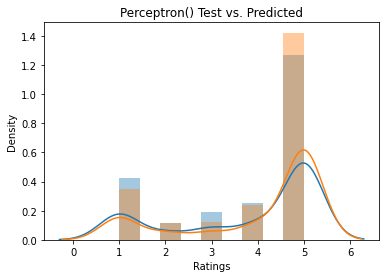

In [14]:
mk1 = select_best_model_score(words_df)

#### Truncated SVD


Best build model is: 
MLPClassifier()
Build model score (Accuracy): 0.6965620328849028
MAE = 0.5022
MSE = 1.1061
RMSE = 1.0517


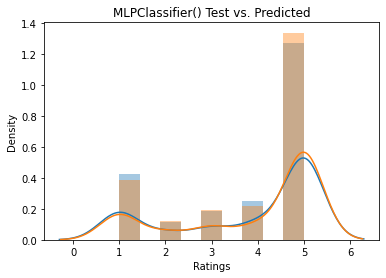

In [15]:
mk2 = select_best_model_score(t)

### Predicting a Positive Rating (3+ Stars)

In [16]:
t['Rating'] = t['Rating'].apply(lambda x: 1 if x > 2 else 0)
words_df['Rating'] = words_df['Rating'].apply(lambda x: 1 if x > 2 else 0)

#### TF-IDF Data


Best build model is: 
LinearSVC()
Build model score (Accuracy): 0.9088191330343797
MAE = 0.0912
MSE = 0.0912
RMSE = 0.3020
Accuracy: 0.9088191330343797
Precision: 0.9162011173184358
Recall: 0.968503937007874


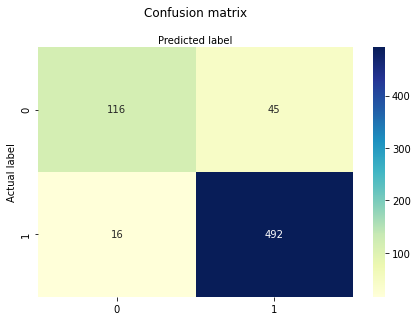

In [17]:
mk3 = select_best_model_score(words_df)

#### Truncated SVD


Best build model is: 
LinearSVC()
Build model score (Accuracy): 0.9043348281016442
MAE = 0.0957
MSE = 0.0957
RMSE = 0.3093
Accuracy: 0.9043348281016442
Precision: 0.9188679245283019
Recall: 0.9586614173228346


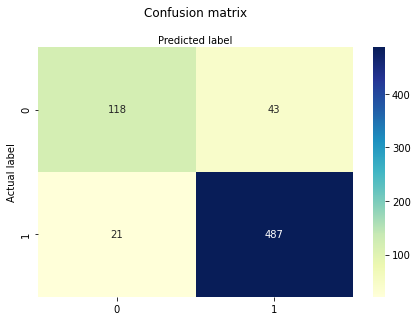

In [18]:
mk4 = select_best_model_score(t)

### Predicting a Negative Review (1-Star)

In [19]:
words_df['Rating'] = reviews['Rating']
t['Rating'] = reviews['Rating']
t['Rating'] = t['Rating'].apply(lambda x: 1 if x == 1 else 0)
words_df['Rating'] = words_df['Rating'].apply(lambda x: 1 if x == 1 else 0)

#### TF-IDF Data


Best build model is: 
SGDClassifier()
Build model score (Accuracy): 0.9103139013452914
MAE = 0.0897
MSE = 0.0897
RMSE = 0.2995
Accuracy: 0.9103139013452914
Precision: 0.8055555555555556
Recall: 0.6904761904761905


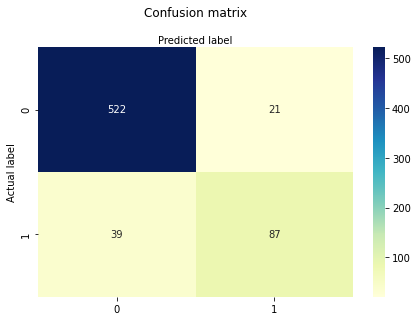

In [20]:
mk5 = select_best_model_score(words_df)

#### Truncated SVD


Best build model is: 
LinearSVC()
Build model score (Accuracy): 0.9133034379671151
MAE = 0.0867
MSE = 0.0867
RMSE = 0.2944
Accuracy: 0.9133034379671151
Precision: 0.8469387755102041
Recall: 0.6587301587301587


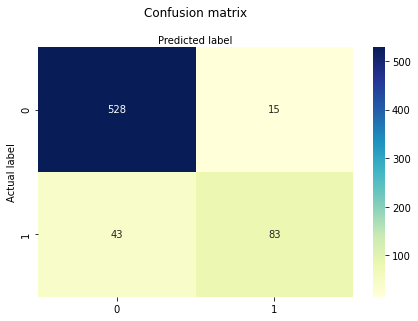

In [21]:
mk6 = select_best_model_score(t)

## Conclusion

After running our automated machine learning function, we were able to understand a couple of trends.

* For exact rating classification, the best models were Perceptrons and MLPClassifiers. This makese sense they are neural network models that tend to work best with data that has high dimensionality like ours.

* Linear SVC models seemed to do best overall for the rest of the modeling outputs.

One further piece we would want to validate is expanding our dataset to test for overfitting. With the exception of truncated SVD, we will have more attributes than observations, so we will want to make sure we can reduce the risk of overfitting.

In conclusion, we would want to export the neural network and LinSVC models to help laptop / reviewing companies. Since they run on reduced dimensionality, they return better results and in a shorter timeframe as well. In the next steps below I will highlight how we can implement this model into production to drive business value.

## Next Steps & Business Implementation

There are two key improvments we will make to improve our model's effectiveness for enterprise level servicing.

Firstly, we will expand our Amazon API subscription / develop web scraping to increase a) the number of API calls for products we can look at and b) the number of reviews we can pull per product. In our implementation above, we used ~ 400 calls and we're only getting a depth of 10 reviews. We would like to remove these limits to improve review volume.

As for the implementation, there are three key steps.

First, the model must be stored and run on an Azure/AWS server. This is important because it allows for secure and scalable storage and performance for our model. We would also be able to create a load balancer for security and availability.

Secondly, we must develop an API that can 1) receive reviews data from clients, 2) store client subscription keys and 3) send back predictive outputs in a timely manner. 

Lastly, we can monetize this API by publishing it to RapidAPI and selling tiered subscriptions. This way, we can have a consistent revenue stream to upkeep to server costs. Due to customer likely to be larger firms, we can charge a premium for unlimited use at a high markup. This would allow us to have a high revenue stream and scale the server instance and model to accomodate demand.